## House Price Predictions

## Imports

In [1]:
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

## Loading the Data

In [2]:
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv",index_col = "Id")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv",index_col = "Id")

In [3]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

## EDA Step

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

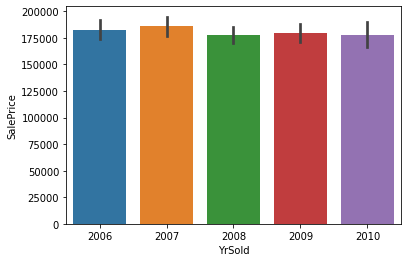

In [5]:

sns.barplot(x = train_df["YrSold"] , y = train_df["SalePrice"])


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

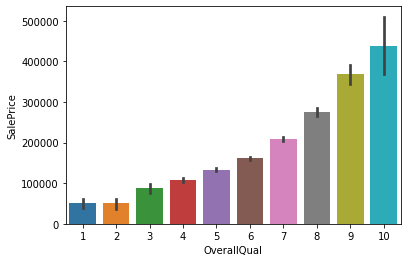

In [6]:
sns.barplot(x = train_df["OverallQual"] , y = train_df["SalePrice"])

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

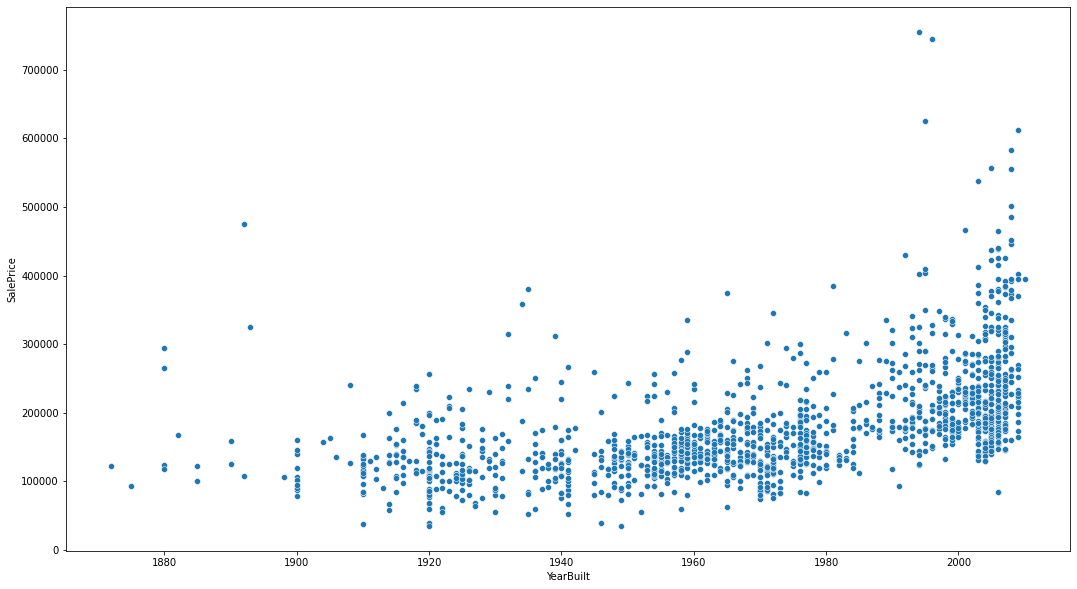

In [7]:
plt.figure(figsize=(18,10))

sns.scatterplot(x = train_df["YearBuilt"] , y = train_df["SalePrice"])

## Search for better features on the data 

In [8]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [9]:
X = train_df.copy()
X = X.fillna("Missing")


y = X.pop("SalePrice")



# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,0,0,8450,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2008,0,0
2,20,0,1,9600,0,0,0,0,0,1,...,0,0,0,0,0,0,5,2007,0,0
3,60,0,2,11250,0,0,1,0,0,0,...,0,0,0,0,0,0,9,2008,0,0
4,70,0,3,9550,0,0,1,0,0,2,...,0,0,0,0,0,0,2,2006,0,1
5,60,0,4,14260,0,0,1,0,0,1,...,0,0,0,0,0,0,12,2008,0,0


In [10]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[:10]  # show a few features with their MI scores

OverallQual     0.567116
Neighborhood    0.526203
GarageArea      0.498501
GrLivArea       0.431459
YearBuilt       0.410751
TotalBsmtSF     0.396154
LotArea         0.392893
GarageCars      0.364345
GarageYrBlt     0.344323
BsmtQual        0.326514
Name: MI Scores, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Neighborhood'>

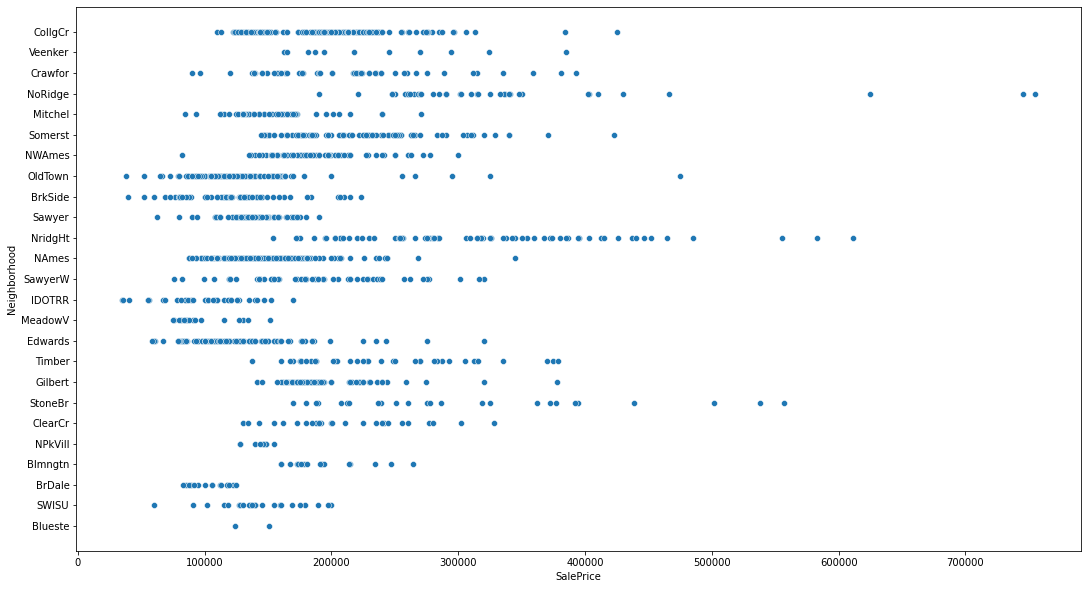

In [11]:
plt.figure(figsize=(18,10))
sns.scatterplot(x = train_df["SalePrice"], y = train_df["Neighborhood"])

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

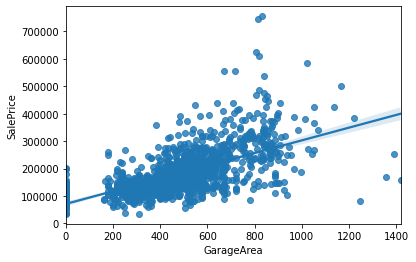

In [12]:
sns.regplot(x = train_df["GarageArea"] , y = train_df["SalePrice"])

## As we can see, MI scores are handy for feature selection
## Now Let's look at the worst MI scored data, and see what we can do to increase their effectiveness  

In [13]:
mi_scores[len(mi_scores)-10:]

YrSold        3.481479e-03
3SsnPorch     2.448806e-03
MiscVal       2.369372e-03
Condition2    1.782305e-03
BsmtFinSF2    6.437672e-04
Utilities     1.887379e-15
PoolArea      2.220446e-16
Street        0.000000e+00
PoolQC        0.000000e+00
MoSold        0.000000e+00
Name: MI Scores, dtype: float64

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

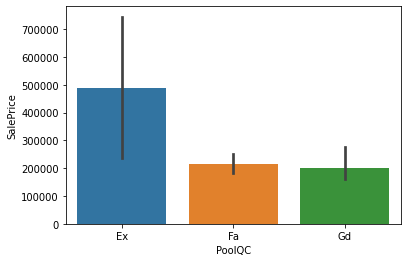

In [14]:
sns.barplot(x = train_df["PoolQC"],y = train_df["SalePrice"])

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

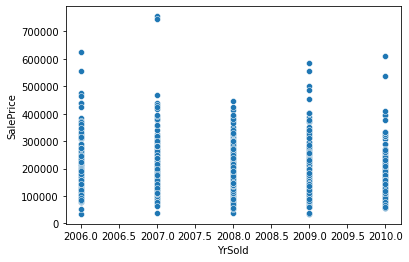

In [15]:
sns.scatterplot(x = train_df["YrSold"],y = train_df["SalePrice"])

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice'>

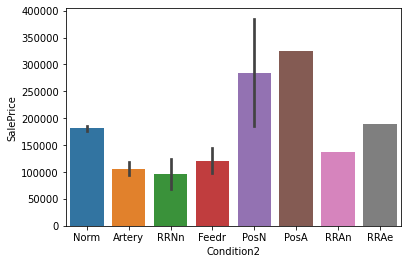

In [16]:
sns.barplot(x = train_df["Condition2"],y = train_df["SalePrice"])

<AxesSubplot:xlabel='MoSold', ylabel='SalePrice'>

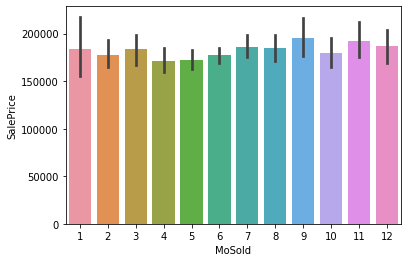

In [17]:
sns.barplot(x = train_df["MoSold"],y = train_df["SalePrice"])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 75.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

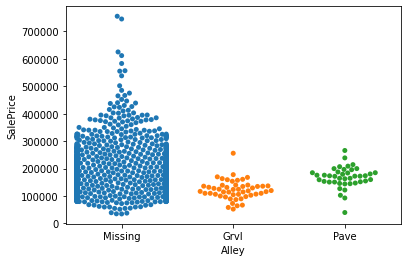

In [18]:
t = train_df.copy()
t = t.fillna("Missing")
sns.swarmplot(x = t["Alley"],y = train_df["SalePrice"])


## Some Features seem to be ok even though it has low MI score lets evaluate our data


In [19]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [21]:
print("MAE Score: ")
print(score_dataset(X_train_full, X_valid_full, y_train, y_valid))

MAE Score: 
17821.92582191781


In [22]:
X_train_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,0,48,11694,0,0,0,0,0,0,...,260,0,0,0,0,0,7,2007,1,2
871,20,0,3,6600,0,0,0,0,0,0,...,0,0,0,0,0,0,8,2009,0,0
93,30,0,1,13360,0,1,1,3,0,0,...,0,0,0,0,0,0,8,2009,0,0
818,20,0,7,13265,0,0,1,0,0,3,...,0,0,0,0,0,0,7,2008,0,0
303,20,0,76,13704,0,0,1,0,0,2,...,0,0,0,0,0,0,1,2006,0,0


In [23]:
train_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv",index_col = "Id")
test_df = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv",index_col = "Id")

In [24]:
def label_encode(df):
    X = df.copy()
    for name in df.select_dtypes("number"):
        X[name] = X[name].fillna(0)
    for name in df.select_dtypes("category"):
        X[name] = X[name].fillna("None")
        
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()
        
    
    
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
        
    return X

In [25]:
def pca_function(X):
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca , X_pca , loadings

In [26]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  
        self.cv_ = KFold(n_splits=5)

   
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [27]:
def create_features(train_df , test_df):
    X = train_df.copy()
    y = X.pop("SalePrice")
    
    
    X_test = test_df.copy()
    
    X = pd.concat([X, test_df])
    
    X = label_encode(X)
   
    pca , X_pca , loadings = pca_function(X)
    X["PC1"] = X_pca["PC1"]
    X["PC2"] = X_pca["PC2"]
    X["PC5"] = X_pca["PC5"]
    
    X_test = X.loc[test_df.index, :]
    X.drop(test_df.index, inplace=True)
    
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    
    X = X.join(encoder.fit_transform(X, y, cols=["Neighborhood"]))
    X_test = X_test.join(encoder.transform(X_test))
    
    return X, X_test

In [28]:
def score_dataset(X, y, model=XGBRegressor()):
  
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [29]:
#train_df, test_df = load_data()

X_train , X_test = create_features(train_df,test_df)
#print(X_train.head())
y_train = train_df.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.14329210445060384

In [30]:
X_train ,X_test = create_features(train_df , test_df)
y_train = train_df.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
    gpu_id = 0,
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0.12819481019338239

In [31]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
xgb_params = study.best_params

[I 2021-08-16 19:10:16,085] A new study created in memory with name: no-name-89451541-e133-4666-9561-5dc7cc58bd59
[I 2021-08-16 19:10:31,477] Trial 0 finished with value: 0.12680588597624062 and parameters: {'max_depth': 7, 'learning_rate': 0.07803234165965593, 'n_estimators': 1526, 'min_child_weight': 4, 'colsample_bytree': 0.30403264062842744, 'subsample': 0.6286443074173707, 'reg_alpha': 0.00031381080280975425, 'reg_lambda': 0.00043645470781242534}. Best is trial 0 with value: 0.12680588597624062.
[I 2021-08-16 19:11:19,667] Trial 1 finished with value: 2.4526782970570413 and parameters: {'max_depth': 7, 'learning_rate': 0.00020356800347467064, 'n_estimators': 7810, 'min_child_weight': 10, 'colsample_bytree': 0.7733611200915897, 'subsample': 0.5238066318318986, 'reg_alpha': 0.0005676012104291944, 'reg_lambda': 11.492269095783685}. Best is trial 0 with value: 0.12680588597624062.
[I 2021-08-16 19:12:04,029] Trial 2 finished with value: 0.12480163114163324 and parameters: {'max_depth'

In [32]:
X_train ,X_test = create_features(train_df , test_df)
y_train = train_df.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)

xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Your submission was successfully saved!
